In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
# import hdbscan
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster import cluster_visualizer

In [2]:
X = pd.read_csv("DataVersion3.csv")
X.drop(["ad_id"], axis = 1, inplace = True)

In [3]:
data_reduced_dim = pd.read_csv("TruncatedSVD_50.csv", header = None)

In [4]:
data = np.column_stack((data_reduced_dim.values, X[["price_in_billion"]].values))

In [5]:
data.shape

(25794, 51)

In [ ]:
X.columns

# Create a distance combined of hamming and euclidean distance

In [7]:
binary_features = X.iloc[:, 8:].values  # Convert to NumPy array
continuous_features = X.iloc[:, :8].values  # Convert to NumPy array

In [ ]:
continuous_features.columns

1. Slow way

In [ ]:
# Compute Hamming distance for binary features
hamming_dist = pairwise_distances(binary_features, metric='hamming')

In [ ]:
# Standardize continuous features before computing Euclidean distance
scaler = StandardScaler()
continuous_features_scaled = scaler.fit_transform(continuous_features)
euclidean_dist = pairwise_distances(continuous_features_scaled, metric='euclidean')

2. Faster way

In [ ]:
# # Compute Hamming distance for binary features
# hamming_dist = squareform(pdist(binary_features, metric='hamming'))

# Standardize continuous features before computing Euclidean distance
scaler = StandardScaler()
continuous_features_scaled = scaler.fit_transform(continuous_features)
euclidean_dist = squareform(pdist(continuous_features_scaled, metric='euclidean'))

In [ ]:
# Normalize distances
hamming_dist /= np.max(hamming_dist)
euclidean_dist /= np.max(euclidean_dist)

# Combine the distances
combined_dist = hamming_dist + euclidean_dist

In [ ]:
# HDBSCAN with precomputed distances
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=10)
cluster_labels = clusterer.fit_predict(combined_dist)

# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters found: {n_clusters}')

# If desired, print the first 10 cluster labels
print('First 10 cluster labels:', cluster_labels[:10])

In [12]:
# HDBSCAN with precomputed distances
clusterer = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=10)
cluster_labels = clusterer.fit_predict(data_reduced_dim)

# Print the number of clusters found
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters found: {n_clusters}')

# If desired, print the first 10 cluster labels
print('First 10 cluster labels:', cluster_labels[:10])

Number of clusters found: 618
First 10 cluster labels: [ 13 604 113  -1  -1  18 446  -1  50  53]


Number of clusters: 11206


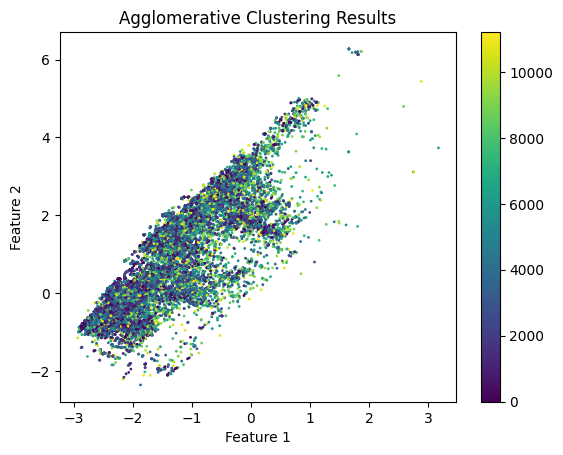

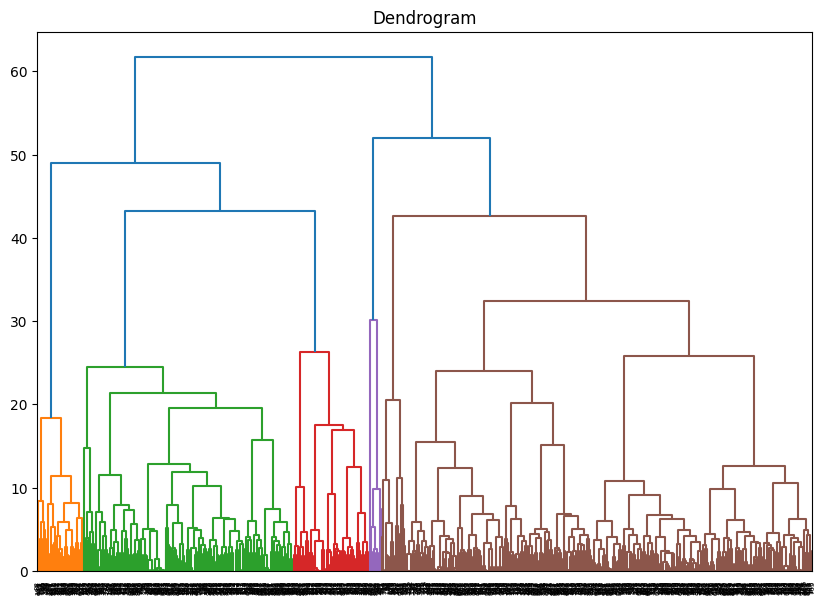

In [6]:
# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters = None, linkage = 'ward', distance_threshold = 0.5)
cluster_labels = clustering.fit_predict(data_reduced_dim)

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters: {n_clusters}')

# Optionally, visualize the first two features of the dataset and color by cluster label
plt.scatter(data_reduced_dim[:, 0], data_reduced_dim[:, 1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar()
plt.title("Agglomerative Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Optionally, create a dendrogram
Z = linkage(data_reduced_dim[:1000], method='ward')  # Using a subset of data for visualization
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendrogram(Z)
plt.show()


Number of clusters: 32
Calinski-Harabasz score: 1910.5194221018248


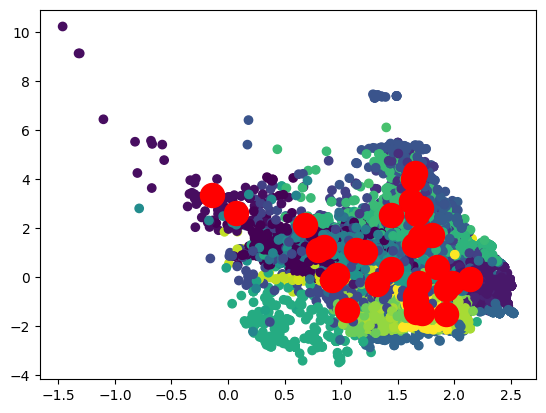

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

class XMeans:
    def __init__(self, k_init=2, k_max=20, random_state=None):
        self.k_init = k_init
        self.k_max = k_max
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X):
        self.cluster_centers_ = self._xmeans(X, self.k_init, self.k_max)
        self.labels_ = self._assign_labels(X, self.cluster_centers_)

    def _xmeans(self, X, k_init, k_max):
        k = k_init
        kmeans = KMeans(n_clusters=k, random_state=self.random_state).fit(X)
        centers = kmeans.cluster_centers_

        while k < k_max:
            new_centers = []
            for i in range(k):
                cluster_points = X[kmeans.labels_ == i]
                if len(cluster_points) <= 1:
                    new_centers.append(centers[i])
                    continue

                kmeans_split = KMeans(n_clusters=2, random_state=self.random_state).fit(cluster_points)
                centers_split = kmeans_split.cluster_centers_

                bic_orig = self._bic(cluster_points, [centers[i]])
                bic_split = self._bic(cluster_points, centers_split)

                if bic_split < bic_orig:
                    new_centers.extend(centers_split)
                else:
                    new_centers.append(centers[i])

            if len(new_centers) == k:
                break
            k = len(new_centers)
            centers = np.array(new_centers)
            kmeans = KMeans(n_clusters=k, random_state=self.random_state).fit(X)
        
        return centers

    def _bic(self, X, centers):
        labels = self._assign_labels(X, centers)
        n_clusters = len(centers)
        n_points, n_features = X.shape

        log_likelihood = 0
        for i in range(n_clusters):
            cluster_points = X[labels == i]
            n_cluster_points = len(cluster_points)
            if n_cluster_points == 0:
                continue
            variance = np.var(cluster_points - centers[i], axis=0).mean()
            log_likelihood += n_cluster_points * np.log(n_cluster_points)
            log_likelihood -= n_cluster_points * np.log(n_points)
            log_likelihood -= n_cluster_points * n_features * np.log(2 * np.pi * variance)
            log_likelihood -= (n_cluster_points - 1) / 2

        return -2 * log_likelihood + n_clusters * np.log(n_points)

    def _assign_labels(self, X, centers):
        distances = cdist(X, centers)
        return np.argmin(distances, axis=1)

    def predict(self, X):
        return self._assign_labels(X, self.cluster_centers_)

# Fit XMeans
xmeans = XMeans(random_state=0)
xmeans.fit(data)
labels = xmeans.labels_
n_clusters = len(np.unique(labels))
calinski_harabasz = calinski_harabasz_score(data, labels)

print(f"Number of clusters: {n_clusters}")
print(f"Calinski-Harabasz score: {calinski_harabasz}")

# Visualize the clustering
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
plt.scatter(xmeans.cluster_centers_[:, 0], xmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()


DBSCAN Clustering - Number of clusters: 37
DBSCAN Clustering - Calinski-Harabasz score: 281.46010546915693


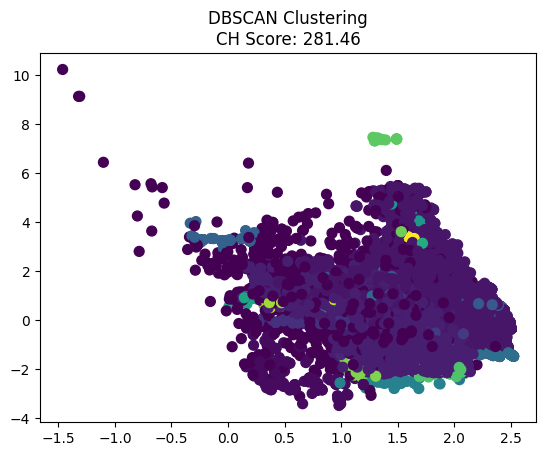

In [20]:
from sklearn.cluster import DBSCAN, MeanShift

# DBSCAN clustering
def dbscan_clustering(X, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    return dbscan.labels_

# Mean Shift clustering
def mean_shift_clustering(X):
    mean_shift = MeanShift().fit(X)
    return mean_shift.labels_

# Evaluate and plot clustering results
def evaluate_and_plot(X, labels, title):
    ch_score = calinski_harabasz_score(X, labels)
    n_clusters = len(np.unique(labels))
    print(f"{title} - Number of clusters: {n_clusters}")
    print(f"{title} - Calinski-Harabasz score: {ch_score}")
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f"{title}\nCH Score: {ch_score:.2f}")
    plt.show()

# DBSCAN clustering and evaluation
labels_dbscan = dbscan_clustering(data, eps=2, min_samples=10)
evaluate_and_plot(data, labels_dbscan, "DBSCAN Clustering")

# Mean Shift clustering and evaluation
# labels_mean_shift = mean_shift_clustering(data)
# evaluate_and_plot(data, labels_mean_shift, "Mean Shift Clustering")


In [11]:
data.shape

(25794, 51)